<a href="https://colab.research.google.com/github/1985shree/1985shree/blob/main/tender_recommender_with_joined_tables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing modules

In [311]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer
import re
import spacy
# nlp = spacy.load('en_core_web_lg')
# spacy_tokenizer = Tokenizer(nlp.vocab)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import save_npz, load_npz

import seaborn as sns
import matplotlib.pyplot as plt



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [312]:
pd.options.display.max_colwidth = 1000

# Importing dataset

In [313]:
items = pd.read_csv('items.csv')
userint = pd.read_csv('userInteractions.csv')
users = pd.read_csv('users.csv')


In [314]:
items.head()

,id,authority,publishingDate,bidDeadline,value,emd,status,locations,details
0,7e5e42eb-de7d-4b63-bd8c-9a842c445e66,Directorate Of Rural Development,1.645277e+12,1.645787e+12,300000.0,6000.0,CANCELLED,"[{'state': 'Jammu & Kashmir', 'city': 'Kathua'}]",Construction Of Community Sanitary Complex Unit At Near Gms Rohat Pyt Kah Block Nagrota Gujrooo
1,828d3851-105f-4c24-ae68-c5b24597c7e7,Jharkhand State Rural Road Development Authority,1.645247e+12,1.646048e+12,16861000.0,339000.0,PUBLISHED,"[{'state': 'Jharkhand', 'city': 'Ranchi'}]",Repair And Maintenance Of Pmgsy Roads
2,673074b9-8592-4682-a4e4-ee388a1d86c5,Jharkhand State Rural Road Development Authority,1.645247e+12,1.646048e+12,32778000.0,656000.0,PUBLISHED,"[{'state': 'Jharkhand', 'city': 'West Singhbhum'}]",Repair And Maintenance Of Pmgsy Roads
3,836737ee-1d1d-4ae7-86f8-0c5abb8823c4,Jharkhand State Rural Road Development Authority,1.645247e+12,1.646048e+12,52264000.0,1045000.0,PUBLISHED,"[{'state': 'Jharkhand', 'city': 'Garhwa'}]",Repair And Maintenance Of Pmgsy Roads
4,929d94a1-0921-4625-9630-2720ee762f50,Rural Development Department,1.645270e+12,1.645760e+12,375755.0,NaN,ARCHIVED,"[{'state': 'Maharashtra', 'city': 'Nanded'}]",Construction Of Closed C.c. Drain / Road At Dapka Gundopant Tq Mukhed Dist Nanded (under 15th Fin Comm 2020-21)


In [315]:
items.shape

(76223, 9)

In [316]:
userint.head()

,activity,entityId,accountId
0,VIEWED,6658c6db-7b22-4612-b14b-edcdfe3f61c4,794928084817024957
1,DOWNLOADED,0c5b4a9d-21c8-428b-bce4-ee27556ba49d,794929730519308433
2,VIEWED,0c5b4a9d-21c8-428b-bce4-ee27556ba49d,794929730519308433
3,DOWNLOADED,817f9dbd-c37c-4e47-af18-01d3c2d25e41,794934903824193736
4,VIEWED,817f9dbd-c37c-4e47-af18-01d3c2d25e41,794934903824193736


In [317]:
userint.shape

(40466, 3)

In [318]:
users.head()

,accountId,filter
0,794928084817024957,"{'KEYWORD': ['Delhi', 'House Keeping']}"
1,794929730519308433,NaN
2,794934903824193736,"{'KEYWORD': ['Power'], 'PURCHASER_NAME': ['GUNTUR DIV']}"
3,711046096666759540,{}
4,6599911511613774475,"{'LOCATION_STRING': ['Kerala'], 'KEYWORD': ['acp', 'exterior', 'glass', 'interior', 'structural glazing', 'truss'], 'VALUE': ['1000', '10000000']}"


In [319]:
users.rename(columns = {'filter': 'use_details'}, inplace = True) # renamed because 'filter' is also a method and keeps interfering

In [320]:
users.shape

(7566, 2)

# Inner join tables to get values for unique user keys and items id. This table to be used for recommender.

In [321]:
df = users.merge(userint, how = 'inner', on = 'accountId').merge(items, how = 'inner', left_on= 'entityId', right_on = 'id')

In [322]:
df.shape

(11966, 13)

In [323]:
df.head()

,accountId,use_details,activity,entityId,id,authority,publishingDate,bidDeadline,value,emd,status,locations,details
0,6599911511613774475,"{'LOCATION_STRING': ['Kerala'], 'KEYWORD': ['acp', 'exterior', 'glass', 'interior', 'structural glazing', 'truss'], 'VALUE': ['1000', '10000000']}",VIEWED,52cb8cd0-9b31-4f4c-ade2-c5fb00ec8814,52cb8cd0-9b31-4f4c-ade2-c5fb00ec8814,Local Self Government Department,1.645274e+12,1.646224e+12,1606682.0,40200.0,PUBLISHED,"[{'state': 'Kerala', 'city': 'Kollam'}]",Proj No. 53/2021-22 Alayamon Gp Panchayat Office Maintenance
1,6599911511613774475,"{'LOCATION_STRING': ['Kerala'], 'KEYWORD': ['acp', 'exterior', 'glass', 'interior', 'structural glazing', 'truss'], 'VALUE': ['1000', '10000000']}",VIEWED,93094cb5-206c-4cfb-b1ba-9c9d4a7d172f,93094cb5-206c-4cfb-b1ba-9c9d4a7d172f,Local Self Government Department,1.645241e+12,1.645875e+12,2715214.0,50000.0,ARCHIVED,"[{'state': 'Kerala', 'city': 'Kottayam'}]",Pr.no.418.construction Of Smart Anganwadi In Ward No-19
2,6597437160620561202,{},VIEWED,93094cb5-206c-4cfb-b1ba-9c9d4a7d172f,93094cb5-206c-4cfb-b1ba-9c9d4a7d172f,Local Self Government Department,1.645241e+12,1.645875e+12,2715214.0,50000.0,ARCHIVED,"[{'state': 'Kerala', 'city': 'Kottayam'}]",Pr.no.418.construction Of Smart Anganwadi In Ward No-19
3,6599911511613774475,"{'LOCATION_STRING': ['Kerala'], 'KEYWORD': ['acp', 'exterior', 'glass', 'interior', 'structural glazing', 'truss'], 'VALUE': ['1000', '10000000']}",VIEWED,703271eb-cf27-4a12-ae58-d7524e269378,703271eb-cf27-4a12-ae58-d7524e269378,Local Self Government Department,1.645155e+12,1.646123e+12,4065562.0,50000.0,PUBLISHED,"[{'state': 'Kerala', 'city': 'Pathanamthitta'}]",Construction Of First Floor In Panchayat Office Kottanad
4,6599911511613774475,"{'LOCATION_STRING': ['Kerala'], 'KEYWORD': ['acp', 'exterior', 'glass', 'interior', 'structural glazing', 'truss'], 'VALUE': ['1000', '10000000']}",VIEWED,44c5aa55-fe3a-4632-a835-6d3996be05e5,44c5aa55-fe3a-4632-a835-6d3996be05e5,Local Self Government Department,1.645274e+12,1.646044e+12,1581827.0,39600.0,PUBLISHED,"[{'state': 'Kerala', 'city': 'Idukki'}]",Dp Works 2021-22 Ummakkada Dwss In Ward 3 Of Nedumkandam Grama Panchayath(nedumkandam Bp)(pro.no.456/22) E-quotation


<AxesSubplot:>

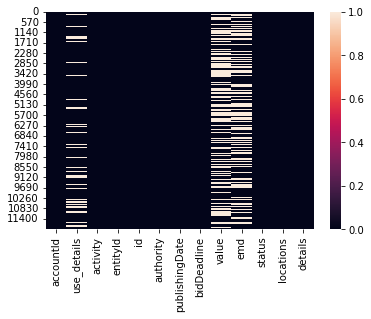

In [324]:
sns.heatmap(df.isnull())

In [ ]:
# user_df.fillna(0)

In [325]:
df = df[df['use_details'].notna()] #got rid of data without any info

In [326]:
df.duplicated().sum()

0

In [327]:
df.shape

(10213, 13)

In [328]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10213 entries, 0 to 11963
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   accountId       10213 non-null  object 
 1   use_details     10213 non-null  object 
 2   activity        10213 non-null  object 
 3   entityId        10213 non-null  object 
 4   id              10213 non-null  object 
 5   authority       10213 non-null  object 
 6   publishingDate  10213 non-null  float64
 7   bidDeadline     10211 non-null  float64
 8   value           5917 non-null   float64
 9   emd             5411 non-null   float64
 10  status          10213 non-null  object 
 11  locations       10213 non-null  object 
 12  details         10213 non-null  object 
dtypes: float64(4), object(9)
memory usage: 1.1+ MB


In [329]:
df.rename(columns = {'filter': 'use_details'}, inplace = True) # renamed because 'filter' is also a method and keeps interfering

In [330]:
df = df.reset_index(drop = True)

In [331]:
df.columns

Index(['accountId', 'use_details', 'activity', 'entityId', 'id', 'authority',
       'publishingDate', 'bidDeadline', 'value', 'emd', 'status', 'locations',
       'details'],
      dtype='object')

## Extract text from details column

In [332]:
df.use_details[10]

"{'LOCATION_STRING': ['Kerala'], 'KEYWORD': ['acp', 'exterior', 'glass', 'interior', 'structural glazing', 'truss'], 'VALUE': ['1000', '10000000']}"

In [333]:
json_data = json.loads(df.use_details[10].replace("'", '"'))
json_val = [val for k, val in json_data.items() if not k == 'VALUE']

In [334]:
json_val

[['Kerala'],
 ['acp', 'exterior', 'glass', 'interior', 'structural glazing', 'truss']]

In [335]:
def json_extractor_text(file):

  corrected = file.replace("'", '"')
  temp_data = json.loads(corrected)
  
  
    
  temp_value = [val for k, val in temp_data.items() if not k == 'VALUE']
  
  
  
  return ' '.join([item for sublist in temp_value for item in sublist])

def json_extractor_arg(file):
  try:
    return json_extractor_text(file)
  except:
    return ''
    



In [336]:
def json_extractor_value(file):

  corrected = file.replace("'", '"')
  temp_data = json.loads(corrected)
  
  
    
  temp_value = [val for k, val in temp_data.items() if k == 'VALUE']
  
  
  
  return [int(item) for sublist in temp_value for item in sublist]

def json_extractor_val_arg(file):
  try:
    return json_extractor_value(file)
  except:
    return ''

In [337]:
json_extractor_text(df.use_details[4]) #trying on one example

'Kerala acp exterior glass interior structural glazing truss'

In [338]:
df['details_text'] = df.use_details.apply(lambda x: json_extractor_arg(x))

In [339]:
df['details_value'] = df.use_details.apply(lambda x: json_extractor_val_arg(x))

In [341]:
df['details_text'][0]

'Kerala acp exterior glass interior structural glazing truss'

In [342]:
df['details_value'][10]

[1000, 10000000]

# performing NER to extract region information from details_text column.

In [ ]:
! python -m spacy download en_core_web_lg

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-10 06:42:45.475626: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-10 06:42:45.475751: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-10 06:42:45.475774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [ ]:
nlp = spacy.load("en_core_web_lg")
nlp

Getting text data for fine-tuning Spacy NER model

In [ ]:
df.columns

Index(['accountId', 'use_details', 'activity', 'entityId', 'details_text',
       'details_value'],
      dtype='object')

In [ ]:
text_data = ' '.join(df.details_text.sample(500))

In [ ]:
text_data

'Civil Civil Construction Construction Consultancy EOI Etp Manpower Pwd Sand Filter Sewage Sewage Treatment Sewage Treatment Plant Water Treatment Western Railway Wtp besan broom bucket civil cleaning cloths cons dalia drain durum wheat dustbin dustpan e-waste eco effluent environment ewaste facility garbage bags installation jaali jeera maintenance management mop nali nepthalene ball operation package pest plant planter ppe recovery remediation sanitization sanitizer sewage sewerage situ solid storage drum stp survillience termite tissue papers and tissue rolls toilet brush toilet cleaner treatment urinal ball urinal screen wall ward waste wastewater wiper Madhya Pradesh Maharashtra Akola Amravati Betul Bhandara Bhopal Dindori Gondia Hoshangabad Indore Jabalpur Katni Mandla Nagpur Seoni Shahdol Wardha CCTV Printing civil works manpower photography road work transportation videogarphy Maharashtra AMC Maintenance Contracts Batteries and Cells and Accessories Cable and Wires Drilling Wor

In [ ]:
with open('train_text.txt', 'w') as fi:
  fi.write(text_data)
  fi.close()

In [ ]:
def extract_locations(text_data):
  doc = nlp(text_data)
  gpe = []
  ent_lab = [e.label_ for e in doc.ents]
  # all_ents = [e.label_ for e in doc.ents if e.label_ == 'GPE' or e.label_ == 'NORP' or e.label_ == 'LOC']
  for ent in doc.ents:
    if ent.label_ == 'GPE':
      gpe.append(ent.text)
    elif ent.label_ == 'NORP':
      gpe.append(ent.text)
    elif ent.label_ == 'LOC':
      gpe.append(ent.text)
    elif ent.label_ == 'ORG':
      gpe.append(ent.text)
    else:
      None

  return ' '.join(gpe)

In [ ]:
extract_locations(df.details_text[5000])


'IAF oxford rain'

##### Not doing it now

In [ ]:
# df['loc_details'] = df.details_text.apply(lambda x: extract_locations(x))

In [ ]:
# df['loc_details']

In [ ]:
def custom_aggregation(*args):
  txt_list = []
  
  for arg in args:
    arg = arg[4:]
    
    txt_list.append(arg)

  if len(txt_list) >2 :

    return np.unique(txt_list).tolist()

  else:
    
    return txt_list


In [ ]:
df.columns

Index(['accountId', 'use_details', 'activity', 'entityId', 'details_text',
       'details_value'],
      dtype='object')

In [ ]:
df_activity = df.groupby('accountId')['details_text'].apply(lambda x: custom_aggregation(x)).to_frame()

In [ ]:
df_activity.reset_index(inplace = True)

In [ ]:
len(df_activity.details_text[0])

1

In [ ]:
df_activity.head()

,accountId,details_text
0,6076439132127629518,[[]]
1,6090418399291119165,[[]]
2,6148417430046643859,"[[Andhra Pradesh Telangana Krishna, Andhra Pra..."
3,6180975557690267471,[[19 inch rack Angle Bracket for Step Hanger E...
4,6261728811314844815,[[3D PRINTING CMM INSPECTIONS Furniture GI W...


In [ ]:
df_activity.details_text[30]

[2046    Plant and machinery scrap
 2047    Plant and machinery scrap
 2048    Plant and machinery scrap
 2049    Plant and machinery scrap
 2050    Plant and machinery scrap
 2051    Plant and machinery scrap
 Name: 6384313597467562204, dtype: object]

# modify items df

In [343]:
df.head()

,accountId,use_details,activity,entityId,id,authority,publishingDate,bidDeadline,value,emd,status,locations,details,details_text,details_value
0,6599911511613774475,"{'LOCATION_STRING': ['Kerala'], 'KEYWORD': ['acp', 'exterior', 'glass', 'interior', 'structural glazing', 'truss'], 'VALUE': ['1000', '10000000']}",VIEWED,52cb8cd0-9b31-4f4c-ade2-c5fb00ec8814,52cb8cd0-9b31-4f4c-ade2-c5fb00ec8814,Local Self Government Department,1.645274e+12,1.646224e+12,1606682.0,40200.0,PUBLISHED,"[{'state': 'Kerala', 'city': 'Kollam'}]",Proj No. 53/2021-22 Alayamon Gp Panchayat Office Maintenance,Kerala acp exterior glass interior structural glazing truss,"[1000, 10000000]"
1,6599911511613774475,"{'LOCATION_STRING': ['Kerala'], 'KEYWORD': ['acp', 'exterior', 'glass', 'interior', 'structural glazing', 'truss'], 'VALUE': ['1000', '10000000']}",VIEWED,93094cb5-206c-4cfb-b1ba-9c9d4a7d172f,93094cb5-206c-4cfb-b1ba-9c9d4a7d172f,Local Self Government Department,1.645241e+12,1.645875e+12,2715214.0,50000.0,ARCHIVED,"[{'state': 'Kerala', 'city': 'Kottayam'}]",Pr.no.418.construction Of Smart Anganwadi In Ward No-19,Kerala acp exterior glass interior structural glazing truss,"[1000, 10000000]"
2,6597437160620561202,{},VIEWED,93094cb5-206c-4cfb-b1ba-9c9d4a7d172f,93094cb5-206c-4cfb-b1ba-9c9d4a7d172f,Local Self Government Department,1.645241e+12,1.645875e+12,2715214.0,50000.0,ARCHIVED,"[{'state': 'Kerala', 'city': 'Kottayam'}]",Pr.no.418.construction Of Smart Anganwadi In Ward No-19,,[]
3,6599911511613774475,"{'LOCATION_STRING': ['Kerala'], 'KEYWORD': ['acp', 'exterior', 'glass', 'interior', 'structural glazing', 'truss'], 'VALUE': ['1000', '10000000']}",VIEWED,703271eb-cf27-4a12-ae58-d7524e269378,703271eb-cf27-4a12-ae58-d7524e269378,Local Self Government Department,1.645155e+12,1.646123e+12,4065562.0,50000.0,PUBLISHED,"[{'state': 'Kerala', 'city': 'Pathanamthitta'}]",Construction Of First Floor In Panchayat Office Kottanad,Kerala acp exterior glass interior structural glazing truss,"[1000, 10000000]"
4,6599911511613774475,"{'LOCATION_STRING': ['Kerala'], 'KEYWORD': ['acp', 'exterior', 'glass', 'interior', 'structural glazing', 'truss'], 'VALUE': ['1000', '10000000']}",VIEWED,44c5aa55-fe3a-4632-a835-6d3996be05e5,44c5aa55-fe3a-4632-a835-6d3996be05e5,Local Self Government Department,1.645274e+12,1.646044e+12,1581827.0,39600.0,PUBLISHED,"[{'state': 'Kerala', 'city': 'Idukki'}]",Dp Works 2021-22 Ummakkada Dwss In Ward 3 Of Nedumkandam Grama Panchayath(nedumkandam Bp)(pro.no.456/22) E-quotation,Kerala acp exterior glass interior structural glazing truss,"[1000, 10000000]"


In [344]:
df.details_text[4]

'Kerala acp exterior glass interior structural glazing truss'

In [345]:
df.details[4]

'Dp Works 2021-22 Ummakkada Dwss In Ward 3 Of Nedumkandam Grama Panchayath(nedumkandam Bp)(pro.no.456/22) E-quotation'

In [124]:
# df['text'] = df.details_text + df.details

In [125]:
# df['text'][0]

In [346]:
def json_extractor_state(file):

  corrected = file.replace("'", '"')
  temp_data = json.loads(corrected)
  
  
    
  temp_value = [val for k, val in temp_data[0].items() if k == 'state']
  
  
  
  return ''.join([item for sublist in temp_value for item in sublist])
  # return temp_data

def json_extractor_state_arg(file):
  try:
    return json_extractor_state(file)
  except:
    return ''

In [347]:
json_extractor_state(df.locations[0])

'Kerala'

In [348]:
df['state'] = df.locations.apply(lambda x: json_extractor_state_arg(x))

In [349]:
df['state']

0                  Kerala
1                  Kerala
2                  Kerala
3                  Kerala
4                  Kerala
               ...       
10208           Jharkhand
10209              Kerala
10210    Himachal Pradesh
10211      Andhra Pradesh
10212      Andhra Pradesh
Name: state, Length: 10213, dtype: object

In [350]:
df.isnull().sum()

accountId            0
use_details          0
activity             0
entityId             0
id                   0
authority            0
publishingDate       0
bidDeadline          2
value             4296
emd               4802
status               0
locations            0
details              0
details_text         0
details_value        0
state                0
dtype: int64

In [351]:
df.shape

(10213, 16)

# Extrecting relevant columns for vectorization and cosine similarity calculation.

In [352]:
df.columns

Index(['accountId', 'use_details', 'activity', 'entityId', 'id', 'authority',
       'publishingDate', 'bidDeadline', 'value', 'emd', 'status', 'locations',
       'details', 'details_text', 'details_value', 'state'],
      dtype='object')

In [353]:
# df_group = df.groupby(['accountId', 'details_text', 'id'])['details'].apply(list).to_frame()

In [354]:
def filter_duplicates(lst):
  unique_lst = []
  dup_list = []
  for v in lst:
    if v not in unique_lst:
      unique_lst.append(v)
    else:
      dup_list.append(v)
  return ''.join(unique_lst)

In [355]:
def filter_id(lst):
  unique_lst = []
  dup_list = []
  for v in lst:
    if v not in unique_lst:
      unique_lst.append(v)
    else:
      dup_list.append(v)
  return unique_lst

In [356]:
df_1 = df.groupby('accountId')['details_text'].apply(list).to_frame()
df_1['unique_details_text'] = df_1.details_text.apply(lambda x: filter_duplicates(x))
df_2 = df.groupby('accountId')['details'].apply(list).to_frame()
df_2['unique_details'] = df_2.details.apply(lambda x: filter_duplicates(x))
df_3 = df.groupby('accountId')['id'].apply(list).to_frame()
df_3['unique_id'] = df_3.id.apply(lambda x: filter_id(x))

In [357]:
df_recommend = df_1.merge(df_2, how = 'inner', on = 'accountId').merge(df_3, how = 'inner', on = 'accountId')

In [358]:
df_recommend = df_recommend.reset_index()

In [359]:
df_recommend.head()

,accountId,details_text,unique_details_text,details,unique_details,id,unique_id
0,6076439132127629518,[Andhra Pradesh Administration All ASTM D Building Cleaning Construction Paint Painting Railway Road Water],Andhra Pradesh Administration All ASTM D Building Cleaning Construction Paint Painting Railway Road Water,"[Engagement Of Security Services Agency For Providing Security Personnel 42 Nos. Security Guards, 1 Nos. Gunman And 4 Nos.supervisor For Security, Safety, Monitoring, Surveillance And Management Of Traffic At Fp And Emc, Gazipur]","Engagement Of Security Services Agency For Providing Security Personnel 42 Nos. Security Guards, 1 Nos. Gunman And 4 Nos.supervisor For Security, Safety, Monitoring, Surveillance And Management Of Traffic At Fp And Emc, Gazipur",[51a36292-c41c-4cdc-bb5b-0427f8973d01],[51a36292-c41c-4cdc-bb5b-0427f8973d01]
1,6090418399291119165,[ENABLE_EXACT_SEARCH ERW Black Pipe ERW Pipes ERW Steel Tubes GI Pipes Galvanized Steel Pipes Galvanized Steel Pipes & Tubes JJM MS Round Pipe galvanized pipe hollow section mild steel ms black pipe ms erw pipe steel pipes structural pipes structural steel pipes],ENABLE_EXACT_SEARCH ERW Black Pipe ERW Pipes ERW Steel Tubes GI Pipes Galvanized Steel Pipes Galvanized Steel Pipes & Tubes JJM MS Round Pipe galvanized pipe hollow section mild steel ms black pipe ms erw pipe steel pipes structural pipes structural steel pipes,"[Thread Ring Gauge-is:14962 , Is:2334]","Thread Ring Gauge-is:14962 , Is:2334",[34294c13-c023-40af-8b78-1a8d86104eb8],[34294c13-c023-40af-8b78-1a8d86104eb8]
2,6148417430046643859,[Andhra Pradesh Telangana Krishna],Andhra Pradesh Telangana Krishna,"[Construction Of New Office Building Of Mercantile Marine Department At Harbour Road, Vishakhapatnam, Andhra Pradesh. S.w. Arrangement Of Inspection Vehicle On Hire Basis For Architect Office, Cpwd At Vijayawada.]","Construction Of New Office Building Of Mercantile Marine Department At Harbour Road, Vishakhapatnam, Andhra Pradesh. S.w. Arrangement Of Inspection Vehicle On Hire Basis For Architect Office, Cpwd At Vijayawada.",[26c72173-5198-483f-bccd-26735a91ceda],[26c72173-5198-483f-bccd-26735a91ceda]
3,6180975557690267471,"[19 inch rack Angle Bracket for Step Hanger Enclosure Frame Galvanised Iron Core Boxes Gi tray Gi trunk Ip55 enclosure Junction box Junction boxip55 Metal Metal enclosure Picket Picket steel Plate Pole box Sheet metal Terminal box Terminal plate Washer Washet bed side table box bracket brackets bunk bed cable duct cable raceway cable tray computer rack connecting plate enclosure equipment rack ladder tray metal bed network rack over bed table perforated perforated cable tray perforated tray picket steel platform trolley rack server rack stool terminal transmission rack trolley tunnel, 19 inch rack Angle Bracket for Step Hanger Enclosure Frame Galvanised Iron Core Boxes Gi tray Gi trunk Ip55 enclosure Junction box Junction boxip55 Metal Metal enclosure Picket Picket steel Plate Pole box Sheet metal Terminal box Terminal plate Washer Washet bed side table box bracket brackets bunk bed cable duct cable raceway cable tray computer rack connecting plate enclosure equipment rack ladder t...",19 inch rack Angle Bracket for Step Hanger Enclosure Frame Galvanised Iron Core Boxes Gi tray Gi trunk Ip55 enclosure Junction box Junction boxip55 Metal Metal enclosure Picket Picket steel Plate Pole box Sheet metal Terminal box Terminal plate Washer Washet bed side table box bracket brackets bunk bed cable duct cable raceway cable tray computer rack connecting plate enclosure equipment rack ladder tray metal bed network rack over bed table perforated perforated cable tray perforated tray picket steel platform trolley rack server rack stool terminal transmission rack trolley tunnel,"[Supply Of 19"" 24u Rack Enclosure Networking/server Rack As Per Specification, Supply Of 19"" 24u Rack Enclosure Networking/server Rack As Per Specification, Patient Bed Side Table, Patient Bed Side Table, Terminal Box, Term

In [360]:
df_recommend['text'] = df_recommend.unique_details_text + df_recommend.unique_details

In [361]:
df_recommend.shape

(2075, 8)

# creating a recommender

#### first let's make a content-based one (based on cosine similarity)

In [362]:
df_recommend.head()

,accountId,details_text,unique_details_text,details,unique_details,id,unique_id,text
0,6076439132127629518,[Andhra Pradesh Administration All ASTM D Building Cleaning Construction Paint Painting Railway Road Water],Andhra Pradesh Administration All ASTM D Building Cleaning Construction Paint Painting Railway Road Water,"[Engagement Of Security Services Agency For Providing Security Personnel 42 Nos. Security Guards, 1 Nos. Gunman And 4 Nos.supervisor For Security, Safety, Monitoring, Surveillance And Management Of Traffic At Fp And Emc, Gazipur]","Engagement Of Security Services Agency For Providing Security Personnel 42 Nos. Security Guards, 1 Nos. Gunman And 4 Nos.supervisor For Security, Safety, Monitoring, Surveillance And Management Of Traffic At Fp And Emc, Gazipur",[51a36292-c41c-4cdc-bb5b-0427f8973d01],[51a36292-c41c-4cdc-bb5b-0427f8973d01],"Andhra Pradesh Administration All ASTM D Building Cleaning Construction Paint Painting Railway Road WaterEngagement Of Security Services Agency For Providing Security Personnel 42 Nos. Security Guards, 1 Nos. Gunman And 4 Nos.supervisor For Security, Safety, Monitoring, Surveillance And Management Of Traffic At Fp And Emc, Gazipur"
1,6090418399291119165,[ENABLE_EXACT_SEARCH ERW Black Pipe ERW Pipes ERW Steel Tubes GI Pipes Galvanized Steel Pipes Galvanized Steel Pipes & Tubes JJM MS Round Pipe galvanized pipe hollow section mild steel ms black pipe ms erw pipe steel pipes structural pipes structural steel pipes],ENABLE_EXACT_SEARCH ERW Black Pipe ERW Pipes ERW Steel Tubes GI Pipes Galvanized Steel Pipes Galvanized Steel Pipes & Tubes JJM MS Round Pipe galvanized pipe hollow section mild steel ms black pipe ms erw pipe steel pipes structural pipes structural steel pipes,"[Thread Ring Gauge-is:14962 , Is:2334]","Thread Ring Gauge-is:14962 , Is:2334",[34294c13-c023-40af-8b78-1a8d86104eb8],[34294c13-c023-40af-8b78-1a8d86104eb8],"ENABLE_EXACT_SEARCH ERW Black Pipe ERW Pipes ERW Steel Tubes GI Pipes Galvanized Steel Pipes Galvanized Steel Pipes & Tubes JJM MS Round Pipe galvanized pipe hollow section mild steel ms black pipe ms erw pipe steel pipes structural pipes structural steel pipesThread Ring Gauge-is:14962 , Is:2334"
2,6148417430046643859,[Andhra Pradesh Telangana Krishna],Andhra Pradesh Telangana Krishna,"[Construction Of New Office Building Of Mercantile Marine Department At Harbour Road, Vishakhapatnam, Andhra Pradesh. S.w. Arrangement Of Inspection Vehicle On Hire Basis For Architect Office, Cpwd At Vijayawada.]","Construction Of New Office Building Of Mercantile Marine Department At Harbour Road, Vishakhapatnam, Andhra Pradesh. S.w. Arrangement Of Inspection Vehicle On Hire Basis For Architect Office, Cpwd At Vijayawada.",[26c72173-5198-483f-bccd-26735a91ceda],[26c72173-5198-483f-bccd-26735a91ceda],"Andhra Pradesh Telangana KrishnaConstruction Of New Office Building Of Mercantile Marine Department At Harbour Road, Vishakhapatnam, Andhra Pradesh. S.w. Arrangement Of Inspection Vehicle On Hire Basis For Architect Office, Cpwd At Vijayawada."
3,6180975557690267471,"[19 inch rack Angle Bracket for Step Hanger Enclosure Frame Galvanised Iron Core Boxes Gi tray Gi trunk Ip55 enclosure Junction box Junction boxip55 Metal Metal enclosure Picket Picket steel Plate Pole box Sheet metal Terminal box Terminal plate Washer Washet bed side table box bracket brackets bunk bed cable duct cable raceway cable tray computer rack connecting plate enclosure equipment rack ladder tray metal bed network rack over bed table perforated perforated cable tray perforated tray picket steel platform trolley rack server rack stool terminal transmission rack trolley tunnel, 19 inch rack Angle Bracket for Step Hanger Enclosure Frame Galvanised Iron Core Boxes Gi tray Gi trunk Ip55 enclosure Junction box Junction boxip55 Metal Metal enclosure Picket Picket steel Plate Pole box Sheet metal Terminal box Terminal plate Washer Washet bed side table box bracket brackets bunk bed cable duct cable raceway cable tray

### cleaning text function

In [363]:
def clean_string(text,stem="None"):

    final_string = ""

    # make lower
    text = text.lower()
    
    # remove http
    text = re.sub(r"http.*\.[a-z]{2,3}","",text)

    # remove www
    text = re.sub(r"www.*\.[a-z]{2,3}","",text)
    
    # remove line breaks
    text = re.sub(r'\n','',text)

    # remove puncuation
    translator = str.maketrans('','',string.punctuation)
    text = text.translate(translator)

    # remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words.remove("don't")
    useless_words.remove('not')

    text_filtered = [word for word in text if not word in useless_words]

    # remove numbers
    text_filtered = [re.sub(r'\w*\d\w*','',w) for w in text_filtered]

    # stem or lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string
        
def apply_clean_string(df):
   arr = df.apply(lambda x: clean_string(str(x)))
   return pd.DataFrame(arr)  

In [364]:
df_recommend['clean_text'] = df_recommend.text.apply(lambda x: clean_string(''.join(x),stem="None"))

In [365]:
df_recommend['clean_text']

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      andhra pradesh administration astm building cleaning construction paint painting railway road waterengagement security services agency providing security personnel  nos security guards  nos gunman  nossupervisor security safety monitoring surveillance management traffic fp emc gazipur
1                                                                                                                                                                                                  

In [366]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


tfidf = TfidfVectorizer(stop_words="english", min_df=1)

In [367]:
tfidf_matrix = tfidf.fit_transform(df_recommend['clean_text'])
# tfidf_matrix.shape
cosine_sim = tfidf_matrix.dot(tfidf_matrix.T)

In [368]:
cosine_sim.shape

(2075, 2075)

In [369]:
df_recommend.columns

Index(['accountId', 'details_text', 'unique_details_text', 'details',
       'unique_details', 'id', 'unique_id', 'text', 'clean_text'],
      dtype='object')

In [370]:
def get_index(user_id, df = df_recommend):
    ''' this finction grabs the index of dataframe (df_recommend) from a given user id'''
    
    try:
    
     
      df_idx = df.index[df['accountId'] == user_id]
      
      return df_idx

    except:
      return 'no text available for this user'


def get_recommendation(user_id, df = df_recommend):
  try: 
    idx = get_index(user_id)
    sim_scores = list(enumerate(cosine_sim[idx].todense().tolist()[0]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:101]
    recommendation_id = [df_recommend.unique_id.iloc[scores[0]] for scores in sim_scores]
    flat_reco_id = [item for sublist in recommendation_id for item in sublist][:20]

    return flat_reco_id

  except:
    return 'no recommendation available for this user'
    

In [371]:
df_recommend['accountId']

0       6076439132127629518
1       6090418399291119165
2       6148417430046643859
3       6180975557690267471
4       6261728811314844815
               ...         
2070     797418303667576069
2071     797422013181337210
2072     797441274159304878
2073     797448739257062377
2074     797451534953617045
Name: accountId, Length: 2075, dtype: object

In [392]:
recommendations = get_recommendation('6090418399291119165')

In [393]:
recommendations

['e3ff60d2-ad0d-4fc7-addf-dbf343cc8a91',
 '869b73f1-9432-4e80-8d8b-4ab20d63ee26',
 'e77630db-e42f-4a28-b9f2-4a03633b51c4',
 'ed7abb42-0df6-4576-abb3-ec50238c0bbb',
 '191b05af-89e0-4c52-acbe-fb24c59fcc21',
 '96205319-b0be-4c26-9b9a-8b33205efe52',
 '014d7647-0c60-4741-82e8-c08a2d15dc7c',
 '24983ebc-9c94-472b-a6c1-3222cb949463',
 '900ff407-85e5-4161-a7e4-0aca4ac7e3bd',
 'c870355f-d159-45cc-ac64-9ac1e5abeb07',
 '0eca6fef-9b8e-48e6-9ef8-66a81fbea8f7',
 'ea78be62-ad56-4067-848c-562352d07fae',
 'ef4103fc-c0de-4246-9588-f8340d6ba665',
 '07b097eb-dcd3-44a7-a61a-f9afb2bba0df',
 '49198123-06cb-483a-97e4-8296b913decf',
 '4285ab09-16bd-45ae-9b70-df0c905303d8',
 '63c16899-704f-456b-8195-c425b2bebcbc',
 '63172226-2f6e-49ce-94b0-dc30668cca5a',
 'b3c35664-f806-4862-a3b9-e956e306884b',
 '5d084ffb-3c77-401d-a2a0-1877aa80af58']

# Manually checking the goodness of recommendations

In [394]:
def get_user_history(user_id, df = df_recommend):

  # df[df['accountId']== user_id]['use_details'].apply(lambda x: json_extractor_text(x))
  return df[df['accountId']== user_id]['text']
  # .apply(lambda x: json_extractor_text(x))

In [396]:
get_user_history('6090418399291119165')

1    ENABLE_EXACT_SEARCH ERW Black Pipe ERW Pipes ERW Steel Tubes GI Pipes Galvanized Steel Pipes Galvanized Steel Pipes & Tubes JJM MS Round Pipe galvanized pipe hollow section mild steel ms black pipe ms erw pipe steel pipes structural pipes structural steel pipesThread Ring Gauge-is:14962 , Is:2334
Name: text, dtype: object

In [397]:
def check_tender_reco_details(*args, df = items):
  reco_rank = []
  reco_text = []

  for i, arg in enumerate(*args):
    
    reco_text.append(df[df['id'] == arg]['details'])
    reco_rank.append(i)
  else: 
    pass
  reco_dict = {'recommendation_rank' : reco_rank, 'recommendation_details' : reco_text}
  return reco_text

In [398]:
check_tender_reco_details(recommendations)

[29757    300064538,300064539 (ag 71758 Gi Pipes)
 Name: details, dtype: object,
 8743    Tender For Supply Of M.s./g.i. Pipe And Pipe Fitting.
 Name: details, dtype: object,
 60413    Supply Of Ms Erw Pipe, Ms Plate And Carbon Steel Seamless Pipe
 Name: details, dtype: object,
 53006    Supply Of Dutron Kanaflex Pipe For Ajava Nimeta Baug
 Name: details, dtype: object,
 30677    Mild Steel Flat Face Flange (200 Mm),mild Steel Steam Bend (200 Mm Dia),mild Steel Pipe With Flange
 Name: details, dtype: object,
 28155    Ball Bearings-is:6455,ball Bearings-is:6455,ball B...
 Name: details, dtype: object,
 26649    Pp-r Pipe 75 Mm,pp-r Pipe 50 Mm,pp-r Pipe 40 Mm,pp...
 Name: details, dtype: object,
 5422    Fixing Arrangement Of Stainless Steel Dust Bin .
 Name: details, dtype: object,
 4822    Supply Of Stainless Steel Litter Bin Below Outside Wash Basin.
 Name: details, dtype: object,
 8406    Construction Of Steel Structure And Painting At Jankalyan Raktpedhi Mahad
 Name: details, dtype

In [243]:
# sim_scores = list(enumerate(cosine_sim[idx].todense().tolist()[0]))
# sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
# sim_scores = sim_scores[1:101]

In [254]:
# recommendation_id = [df_recommend.unique_id.iloc[scores[0]] for scores in sim_scores]
# flat_reco_id = [item for sublist in recommendation_id for item in sublist][:20]

In [412]:

def check_tender_reco(*args, df = items):
  reco_rank = []
  reco_text = []
  for i, arg in enumerate(*args):
    
    reco_rank.append(i)
    reco_text.append(df[df['id'] == arg]['details'])
  reco_dict = dict(zip(reco_rank, reco_text))
  return reco_dict

In [413]:
check_tender_reco(recommendations)

{0: 29757    300064538,300064539 (ag 71758 Gi Pipes)
 Name: details, dtype: object,
 1: 8743    Tender For Supply Of M.s./g.i. Pipe And Pipe Fitting.
 Name: details, dtype: object,
 2: 60413    Supply Of Ms Erw Pipe, Ms Plate And Carbon Steel Seamless Pipe
 Name: details, dtype: object,
 3: 53006    Supply Of Dutron Kanaflex Pipe For Ajava Nimeta Baug
 Name: details, dtype: object,
 4: 30677    Mild Steel Flat Face Flange (200 Mm),mild Steel Steam Bend (200 Mm Dia),mild Steel Pipe With Flange
 Name: details, dtype: object,
 5: 28155    Ball Bearings-is:6455,ball Bearings-is:6455,ball B...
 Name: details, dtype: object,
 6: 26649    Pp-r Pipe 75 Mm,pp-r Pipe 50 Mm,pp-r Pipe 40 Mm,pp...
 Name: details, dtype: object,
 7: 5422    Fixing Arrangement Of Stainless Steel Dust Bin .
 Name: details, dtype: object,
 8: 4822    Supply Of Stainless Steel Litter Bin Below Outside Wash Basin.
 Name: details, dtype: object,
 9: 8406    Construction Of Steel Structure And Painting At Jankalyan Raktped

In [269]:
print(get_user_history('797415879548607667'))

7550    Forest Department ratlam District Collectorate...
Name: use_details, dtype: object


In [ ]:
json_extractor_text